# Keyword Embedding & HDBSCAN Topic Clustering

This notebook:
1. Embeds speech keywords using Turkish sentence-transformers model
2. Clusters speeches using HDBSCAN algorithm
3. Generates topic labels based on representative keywords
4. Uploads new topic assignments to Elasticsearch
5. Visualizes clusters with UMAP

**Model**: `trmteb/turkish-embedding-model-fine-tuned` (768-dimensional embeddings)

**HDBSCAN**: Hierarchical density-based clustering (no need to specify number of clusters)

## 1. Setup and Imports

In [ ]:
!pip install pandas numpy matplotlib seaborn

In [ ]:
!pip install hdbscan  "elasticsearch==8.6.2" tqdm

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Dict, Tuple

# Sentence transformers for embedding
from sentence_transformers import SentenceTransformer

# Clustering
import hdbscan
from sklearn.metrics import silhouette_score

# Dimensionality reduction for visualization
import umap

# Elasticsearch
from elasticsearch import Elasticsearch, helpers
from tqdm.auto import tqdm

# Configuration
KEYWORDS_CSV = "speech_keywords.csv"
EMBEDDINGS_FILE = "keyword_embeddings.npy"
OUTPUT_CSV = "speech_keywords_with_topics.csv"
MODEL_NAME = "trmteb/turkish-embedding-model-fine-tuned"
ELASTICSEARCH_HOST = os.getenv("ELASTICSEARCH_HOST", "http://localhost:9200")
ELASTICSEARCH_INDEX = os.getenv("ELASTICSEARCH_INDEX", "parliament_speeches")

print("✅ Imports complete")

✅ Imports complete


## 2. Load Keywords Data

In [ ]:
# Load the CSV with keywords
print(f"📥 Loading keywords from {KEYWORDS_CSV}...")
df = pd.read_csv(KEYWORDS_CSV)

print(f"\n📊 Dataset info:")
print(f"   Total speeches: {len(df):,}")
print(f"   Columns: {df.columns.tolist()}")

# Display sample
print(f"\n📋 Sample data:")
df.head()

📥 Loading keywords from speech_keywords.csv...

📊 Dataset info:
   Total speeches: 27,201
   Columns: ['speech_id', 'keywords', 'speech_giver', 'year', 'topic_label']

📋 Sample data:


,speech_id,keywords,speech_giver,year,topic_label
0,term26-year3-session82-12,"avukatlar günü, hukuk sistemi, savunma hakkı, ...",Emine Yavuz Gözgeç,3,NaN
1,term26-year3-session82-21,"yargı bağımsızlığı, yargı vesayeti, savunma ha...",Engin Altay,3,NaN
2,term26-year3-session82-23,"Avukatlar Günü, Savunma mesleği, Hukuka uygunl...",Özgür Özel,3,NaN
3,term24-year2-session91-1,"avukatlar günü, savunma, avukatlık, barolar, m...",Ayşe Türkmenoğlu,2,NaN
4,term24-year2-session91-3,"savunma hakkı, siyasi müdahaleler, tutuklu avu...",Pervin Buldan,2,NaN


## 3. Load Turkish Embedding Model

In [ ]:
print(f"🔄 Loading model: {MODEL_NAME}...")
print("   This may take a few minutes on first run...\n")

# Load the model
model = SentenceTransformer(MODEL_NAME)

# Check model details
embedding_dim = model.get_sentence_embedding_dimension()
print(f"✅ Model loaded successfully!")
print(f"   Embedding dimension: {embedding_dim}")
print(f"   Max sequence length: {model.max_seq_length}")

🔄 Loading model: trmteb/turkish-embedding-model-fine-tuned...
   This may take a few minutes on first run...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

✅ Model loaded successfully!
   Embedding dimension: 768
   Max sequence length: 512


## 4. Generate Keyword Embeddings

In [ ]:
def generate_embeddings(keywords_list: List[str], batch_size: int = 32) -> np.ndarray:
    """
    Generate embeddings for a list of keyword strings.

    Args:
        keywords_list: List of comma-separated keyword strings
        batch_size: Batch size for encoding

    Returns:
        numpy array of shape (n_samples, embedding_dim)
    """
    print(f"\n🔄 Generating embeddings for {len(keywords_list):,} speeches...")
    print(f"   Batch size: {batch_size}")

    # Encode in batches with progress bar
    embeddings = model.encode(
        keywords_list,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )

    print(f"\n✅ Embeddings generated!")
    print(f"   Shape: {embeddings.shape}")
    print(f"   Memory: {embeddings.nbytes / 1e6:.2f} MB")

    return embeddings

# Check if embeddings already exist
if os.path.exists(EMBEDDINGS_FILE):
    print(f"\n📂 Found existing embeddings at {EMBEDDINGS_FILE}")
    response = input("Load existing embeddings? (y/n): ")

    if response.lower() == 'y':
        embeddings = np.load(EMBEDDINGS_FILE)
        print(f"✅ Loaded embeddings: {embeddings.shape}")
    else:
        embeddings = generate_embeddings(df['keywords'].tolist())
        np.save(EMBEDDINGS_FILE, embeddings)
        print(f"💾 Saved embeddings to {EMBEDDINGS_FILE}")
else:
    embeddings = generate_embeddings(df['keywords'].tolist())
    np.save(EMBEDDINGS_FILE, embeddings)
    print(f"💾 Saved embeddings to {EMBEDDINGS_FILE}")


📂 Found existing embeddings at keyword_embeddings.npy
Load existing embeddings? (y/n): y
✅ Loaded embeddings: (27201, 768)


In [ ]:
# Reduce 768 dims → 15-30 dims
import umap

reducer = umap.UMAP(
    n_components=50,  # Try 15, 20, or 30
    n_neighbors=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

embeddings = reducer.fit_transform(embeddings)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 5. HDBSCAN Clustering

In [ ]:
def cluster_with_hdbscan(
    embeddings: np.ndarray,
    min_cluster_size: int = 30,
    min_samples: int = 10,
    metric: str = 'euclidean',
    cluster_selection_epsilon: float = 5.0
) -> Tuple[np.ndarray, hdbscan.HDBSCAN]:
    """
    Cluster embeddings using HDBSCAN.

    Args:
        embeddings: numpy array of embeddings
        min_cluster_size: minimum size of clusters
        min_samples: number of samples in a neighborhood
        metric: distance metric to use
        cluster_selection_epsilon: distance threshold for merging clusters

    Returns:
        Tuple of (cluster_labels, clusterer_object)
    """
    print(f"\n🔄 Running HDBSCAN clustering...")
    print(f"   Parameters:")
    print(f"   - min_cluster_size: {min_cluster_size}")
    print(f"   - min_samples: {min_samples}")
    print(f"   - metric: {metric}")
    print(f"   - cluster_selection_epsilon: {cluster_selection_epsilon}")

    # Create and fit clusterer
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_epsilon=cluster_selection_epsilon,
        prediction_data=True
    )

    labels = clusterer.fit_predict(embeddings)

    # Statistics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = np.sum(labels == -1)

    print(f"\n✅ Clustering complete!")
    print(f"   Number of clusters: {n_clusters}")
    print(f"   Outliers: {n_outliers:,} ({n_outliers/len(labels)*100:.1f}%)")
    print(f"   Clustered speeches: {len(labels) - n_outliers:,}")

    return labels, clusterer

# Run clustering with default parameters
# Adjust these parameters based on your data
cluster_labels, clusterer = cluster_with_hdbscan(
    embeddings,
    min_cluster_size=10,
    min_samples=5,
    metric='euclidean'    #epsilon is 0.2
)

# Add to dataframe
df['hdbscan_topic_id'] = cluster_labels


🔄 Running HDBSCAN clustering...
   Parameters:
   - min_cluster_size: 10
   - min_samples: 5
   - metric: euclidean
   - cluster_selection_epsilon: 5.0

✅ Clustering complete!
   Number of clusters: 252
   Outliers: 625 (2.3%)
   Clustered speeches: 26,576


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 6. Cluster Statistics & Analysis

📊 Cluster Size Distribution:

   Cluster  -1 (Outliers):    625 speeches
   Cluster   0:     25 speeches
   Cluster   1:     42 speeches
   Cluster   2:     26 speeches
   Cluster   3:     48 speeches
   Cluster   4:     42 speeches
   Cluster   5:     43 speeches
   Cluster   6:     40 speeches
   Cluster   7:     39 speeches
   Cluster   8:     24 speeches
   Cluster   9:    119 speeches
   Cluster  10:     19 speeches
   Cluster  11:     17 speeches
   Cluster  12:     34 speeches
   Cluster  13:     10 speeches
   Cluster  14:     36 speeches
   Cluster  15:     15 speeches
   Cluster  16:     12 speeches
   Cluster  17:     89 speeches
   Cluster  18:     19 speeches
   Cluster  19:     19 speeches
   Cluster  20:     31 speeches
   Cluster  21:     10 speeches
   Cluster  22:     17 speeches
   Cluster  23:     10 speeches
   Cluster  24:     36 speeches
   Cluster  25:     18 speeches
   Cluster  26:     13 speeches
   Cluster  27:     26 speeches
   Cluster  28:    125 speeches

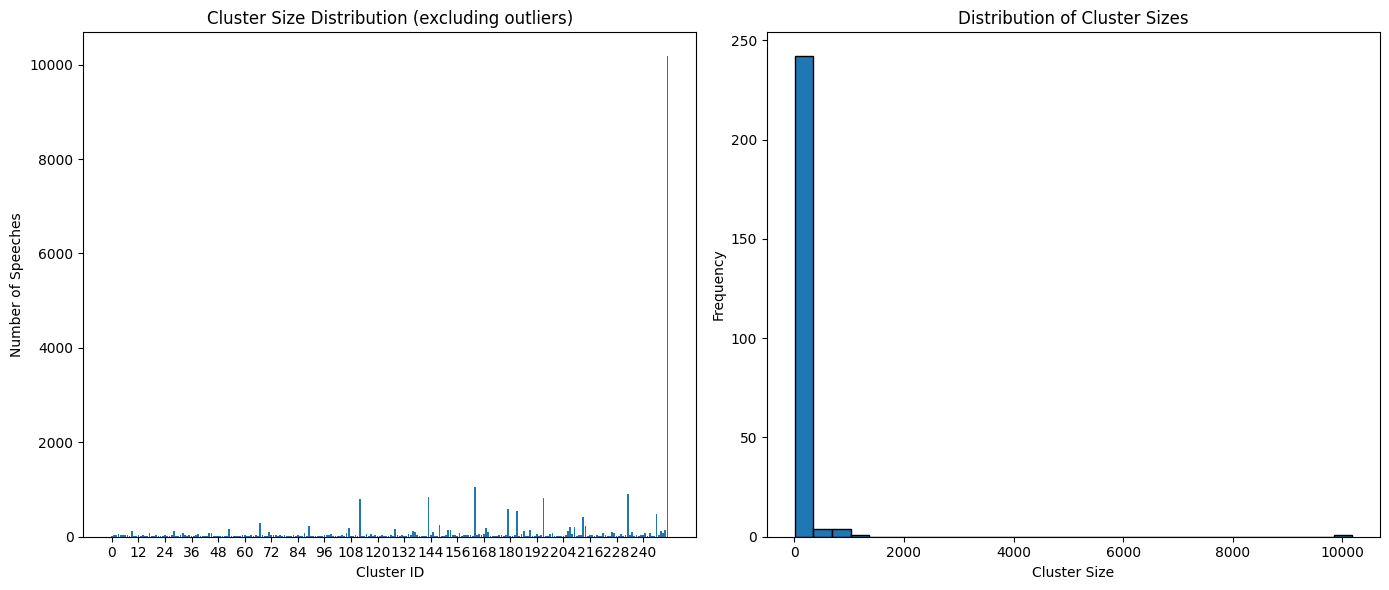


📈 Summary Statistics (excluding outliers):
   Mean cluster size: 105.5
   Median cluster size: 26.0
   Largest cluster: 10,176 speeches
   Smallest cluster: 10 speeches


In [ ]:
# Cluster size distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()

print("📊 Cluster Size Distribution:\n")
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"   Cluster {cluster_id:3d} (Outliers): {count:6,} speeches")
    else:
        print(f"   Cluster {cluster_id:3d}: {count:6,} speeches")

# Plot cluster distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
cluster_counts_no_outliers = cluster_counts[cluster_counts.index != -1]
plt.bar(range(len(cluster_counts_no_outliers)), cluster_counts_no_outliers.values)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Speeches')
plt.title('Cluster Size Distribution (excluding outliers)')
plt.xticks(range(0, len(cluster_counts_no_outliers), max(1, len(cluster_counts_no_outliers)//20)))

plt.subplot(1, 2, 2)
plt.hist(cluster_counts_no_outliers.values, bins=30, edgecolor='black')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Sizes')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 Summary Statistics (excluding outliers):")
print(f"   Mean cluster size: {cluster_counts_no_outliers.mean():.1f}")
print(f"   Median cluster size: {cluster_counts_no_outliers.median():.1f}")
print(f"   Largest cluster: {cluster_counts_no_outliers.max():,} speeches")
print(f"   Smallest cluster: {cluster_counts_no_outliers.min():,} speeches")

## 7. Generate Topic Labels

In [ ]:
def generate_topic_labels(df: pd.DataFrame, n_keywords: int = 5) -> Dict[int, str]:
    """
    Generate topic labels based on most common keywords in each cluster.

    Args:
        df: DataFrame with 'hdbscan_topic_id' and 'keywords' columns
        n_keywords: Number of top keywords to use for label

    Returns:
        Dictionary mapping cluster_id to topic label
    """
    topic_labels = {}

    for cluster_id in sorted(df['hdbscan_topic_id'].unique()):
        # Get all speeches in this cluster
        cluster_speeches = df[df['hdbscan_topic_id'] == cluster_id]

        # Extract all keywords from this cluster
        all_keywords = []
        for keywords_str in cluster_speeches['keywords']:
            if pd.notna(keywords_str):
                keywords = [k.strip() for k in str(keywords_str).split(',')]
                all_keywords.extend(keywords)

        # Count keyword frequencies
        keyword_counts = Counter(all_keywords)

        # Get top N keywords
        top_keywords = [kw for kw, count in keyword_counts.most_common(n_keywords)]

        # Create label
        if cluster_id == -1:
            topic_labels[cluster_id] = "Outliers"
        else:
            topic_labels[cluster_id] = ", ".join(top_keywords)

    return topic_labels

print("🏷️  Generating topic labels...\n")
topic_labels = generate_topic_labels(df, n_keywords=5)

# Add labels to dataframe
df['hdbscan_topic_label'] = df['hdbscan_topic_id'].map(topic_labels)

# Display topics
print("📋 Generated Topics:\n")
for cluster_id, label in sorted(topic_labels.items()):
    count = len(df[df['hdbscan_topic_id'] == cluster_id])
    if cluster_id == -1:
        print(f"   Topic {cluster_id:3d} ({count:6,} speeches): {label}")
    else:
        print(f"   Topic {cluster_id:3d} ({count:6,} speeches): {label[:80]}..." if len(label) > 80 else f"   Topic {cluster_id:3d} ({count:6,} speeches): {label}")

🏷️  Generating topic labels...

📋 Generated Topics:

   Topic  -1 (   625 speeches): Outliers
   Topic   0 (    25 speeches): Nuriye Gülmen, Semih Özakça, açlık grevi, OHAL, KHK
   Topic   1 (    42 speeches): demokrasi, özgürlük, adalet, insan hakları, hukuk devleti
   Topic   2 (    26 speeches): orman, koruma, ağaçlandırma, gelecek nesiller, fidan
   Topic   3 (    48 speeches): Enis Berberoğlu, Anayasa Mahkemesi, Anayasa, adalet, Adalet
   Topic   4 (    42 speeches): Engelliler Haftası, engelliler, engelli, Dünya Engelliler Günü, Anneler Günü
   Topic   5 (    43 speeches): demokrasi, özgürlük, insan hakları, adalet, eğitim
   Topic   6 (    40 speeches): polis, şehit, kuruluş yılı, gazi, güvenlik
   Topic   7 (    39 speeches): demokrasi, özgürlük, adalet, insan hakları, ekonomik büyüme
   Topic   8 (    24 speeches): Dünya Çocuk Hakları Günü, çocuk hakları, Birleşmiş Milletler, yoksulluk, eğitim
   Topic   9 (   119 speeches): Azerbaycan, Ermenistan, Dağlık Karabağ, Karabağ, şeh

## 8. Visualize Clusters with UMAP

🔄 Reducing dimensions with UMAP for visualization...
   This may take a few minutes...



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 317 with accuracies 
[2.04151695e-15 1.75673374e-05 5.35973508e-06 9.07176995e-06]
not reaching the requested tolerance 9.387731552124023e-06.
Use iteration 317 instead with accuracy 
7.999710618192883e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.56238452e-15 1.75673375e-05 5.35973511e-06 9.07176988e-06]
not reaching the requested tolerance 9.387731552124023e-06.
  _, diffusion_map = lobpcg(


✅ Dimensionality reduction complete!


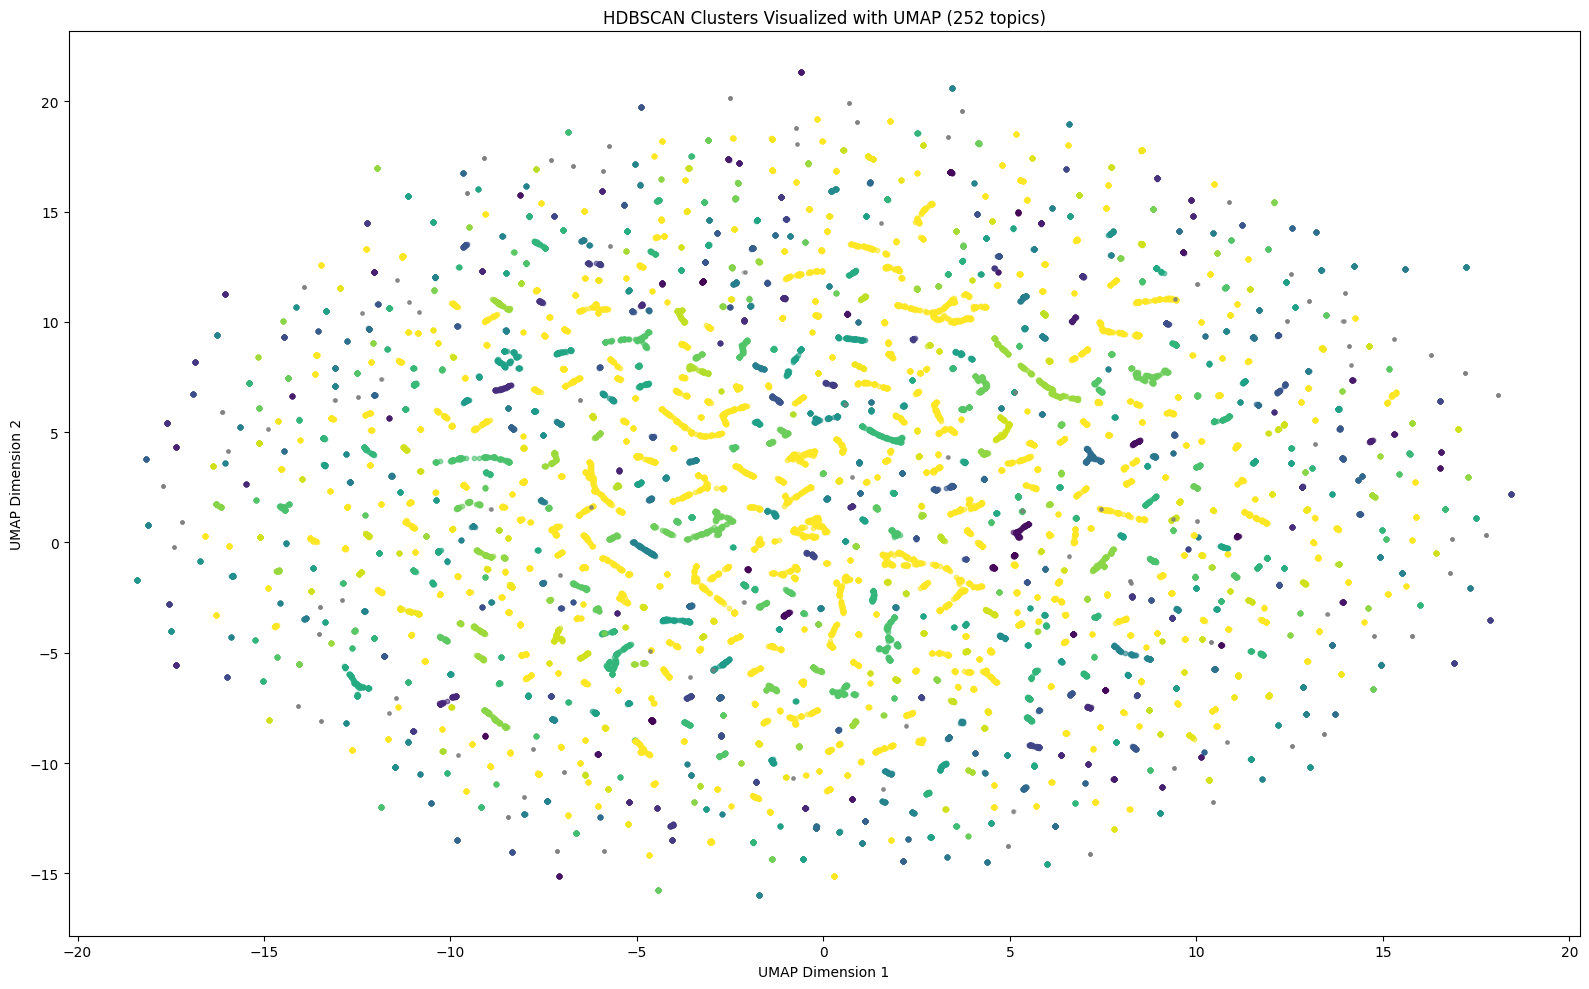


✅ Visualization complete!


In [ ]:
print("🔄 Reducing dimensions with UMAP for visualization...")
print("   This may take a few minutes...\n")

# Reduce to 2D for visualization
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    random_state=42
)

embeddings_2d = reducer.fit_transform(embeddings)

print("✅ Dimensionality reduction complete!")

# Plot
plt.figure(figsize=(16, 10))

# Get unique clusters (excluding outliers for color assignment)
unique_clusters = sorted([c for c in df['hdbscan_topic_id'].unique() if c != -1])
n_clusters = len(unique_clusters)

# Create color map
colors = plt.cm.tab20(np.linspace(0, 1, min(n_clusters, 20)))
if n_clusters > 20:
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Plot each cluster
for idx, cluster_id in enumerate(unique_clusters):
    mask = df['hdbscan_topic_id'] == cluster_id
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[idx % len(colors)]],
        label=f'Topic {cluster_id}' if idx < 20 else '',
        alpha=0.6,
        s=10
    )

# Plot outliers
outlier_mask = df['hdbscan_topic_id'] == -1
if outlier_mask.sum() > 0:
    plt.scatter(
        embeddings_2d[outlier_mask, 0],
        embeddings_2d[outlier_mask, 1],
        c='gray',
        label='Outliers',
        alpha=0.3,
        s=5
    )

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title(f'HDBSCAN Clusters Visualized with UMAP ({n_clusters} topics)')
if n_clusters <= 20:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2)
plt.tight_layout()
plt.show()

print(f"\n✅ Visualization complete!")

## 9. Sample Topics

In [ ]:
# Show sample speeches from largest clusters
print("📋 Sample Speeches from Top 5 Largest Clusters:\n")

top_clusters = df['hdbscan_topic_id'].value_counts().head(6)
top_clusters = top_clusters[top_clusters.index != -1].head(5)

for cluster_id in top_clusters.index:
    cluster_df = df[df['hdbscan_topic_id'] == cluster_id]
    topic_label = topic_labels[cluster_id]

    print(f"\n{'='*80}")
    print(f"Topic {cluster_id}: {topic_label}")
    print(f"Size: {len(cluster_df):,} speeches")
    print(f"{'='*80}")

    # Show 3 sample speeches
    samples = cluster_df.sample(min(3, len(cluster_df)))

    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        print(f"\n{idx}. Speech ID: {row['speech_id']}")
        print(f"   Speaker: {row.get('speech_giver', 'N/A')}")
        print(f"   Keywords: {row['keywords'][:100]}..." if len(str(row['keywords'])) > 100 else f"   Keywords: {row['keywords']}")

📋 Sample Speeches from Top 5 Largest Clusters:


Topic 251: Meclis, şehit, PKK, demokrasi, terör
Size: 10,176 speeches

1. Speech ID: term27-year3-session17-42
   Speaker: Engin Altay
   Keywords: İşkence, İnsan Hakları Komisyonu, Dönüş, Teklif, Sıfır Tüketme Belgesi, İflas, Merkez Bankası, Boşal...

2. Speech ID: term24-year2-session18-3
   Speaker: Aykan Erdemir
   Keywords: Alevi, Burak Kul, Zeki Yılmaz, Cihan Kırmızıgül, Tekirdağ, Galatasaray Üniversitesi, hak, korku impa...

3. Speech ID: term27-year3-session12-27
   Speaker: Cemal Enginyurt
   Keywords: PKK, terörist, yurt dışı, linç, yağmalama, Türk Bayrağı, FETÖ, vatan haini, Antalya, ceza

Topic 164: tarım, sel, çiftçi, köy, yol
Size: 1,056 speeches

1. Speech ID: term26-year3-session48-13
   Speaker: Mahmut Tanal
   Keywords: Çevre ve Şehircilik Bakanlığı, Şanlıurfa, Harran, Tarım arazileri, İmar, Su kanaletleri, Çiftçi, Kre...

2. Speech ID: term27-year5-session76-31
   Speaker: Ahmet Çolakoğlu
   Keywords: aşırı yağış, Fily

## 10. Save Results to CSV

In [ ]:
# Save updated dataframe with topic assignments
print(f"💾 Saving results to {OUTPUT_CSV}...")

df.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Saved! CSV contains:")
print(f"   - speech_id")
print(f"   - keywords")
print(f"   - hdbscan_topic_id")
print(f"   - hdbscan_topic_label")
print(f"   - Other metadata columns")

print(f"\n📊 File info:")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")
print(f"   Size: {os.path.getsize(OUTPUT_CSV) / 1e6:.2f} MB")

# Display sample
print(f"\n📋 Sample output:")
df[['speech_id', 'hdbscan_topic_id', 'hdbscan_topic_label', 'keywords']].head(10)

💾 Saving results to speech_keywords_with_topics.csv...

✅ Saved! CSV contains:
   - speech_id
   - keywords
   - hdbscan_topic_id
   - hdbscan_topic_label
   - Other metadata columns

📊 File info:
   Rows: 27,201
   Columns: 7
   Size: 6.37 MB

📋 Sample output:


,speech_id,hdbscan_topic_id,hdbscan_topic_label,keywords
0,term26-year3-session82-12,251,"Meclis, şehit, PKK, demokrasi, terör","avukatlar günü, hukuk sistemi, savunma hakkı, ..."
1,term26-year3-session82-21,251,"Meclis, şehit, PKK, demokrasi, terör","yargı bağımsızlığı, yargı vesayeti, savunma ha..."
2,term26-year3-session82-23,251,"Meclis, şehit, PKK, demokrasi, terör","Avukatlar Günü, Savunma mesleği, Hukuka uygunl..."
3,term24-year2-session91-1,251,"Meclis, şehit, PKK, demokrasi, terör","avukatlar günü, savunma, avukatlık, barolar, m..."
4,term24-year2-session91-3,251,"Meclis, şehit, PKK, demokrasi, terör","savunma hakkı, siyasi müdahaleler, tutuklu avu..."
5,term24-year2-session91-5,251,"Meclis, şehit, PKK, demokrasi, terör","hukuk, devlet, avukatlar, savunma hakkı, hukuk..."
6,term24-year2-session91-6,251,"Meclis, şehit, PKK, demokrasi, terör","tarafsız, bağımsız, adaletli yargı sistemi, hu..."
7,term24-year2-session91-12,251,"Meclis, şehit, PKK, demokrasi, terör","avukatlar, Avukatlar Günü, demokrasi, kuvvetle..."
8,term23-year4-session83-2,251,"Meclis, şehit, PKK, demokrasi, terör","avukatlık, savunma, yargı, barolar, temel hak ..."
9,term23-year5-session86-3,251,"Meclis, şehit, PKK, demokrasi, terör","adalet, hukuk, avukatlar, Avukatlar Günü, yöne..."


In [ ]:

ELASTICSEARCH_HOST="https://governmental-tribal-showing-roof.trycloudflare.com"

## 11. Upload to Elasticsearch

In [ ]:
def upload_topics_to_elasticsearch(
    df: pd.DataFrame,
    es_host: str,
    es_index: str,
    batch_size: int = 100
) -> Tuple[int, int]:
    """
    Upload HDBSCAN topic assignments to Elasticsearch.

    Args:
        df: DataFrame with speech_id, hdbscan_topic_id, hdbscan_topic_label
        es_host: Elasticsearch host URL
        es_index: Index name
        batch_size: Number of documents to upload at once

    Returns:
        Tuple of (success_count, failure_count)
    """
    print(f"\n🔌 Connecting to Elasticsearch at {es_host}...")

    try:
        es = Elasticsearch(hosts=[es_host])

        if not es.ping():
            print("❌ Could not connect to Elasticsearch")
            return 0, 0

        print(f"✅ Connected to Elasticsearch")
        print(f"\n💾 Uploading {len(df):,} topic assignments...")

        # Prepare bulk update actions
        actions = []
        for _, row in df.iterrows():
            actions.append({
                '_op_type': 'update',
                '_index': es_index,
                '_id': row['speech_id'],
                'doc': {
                    'hdbscan_topic_id': int(row['hdbscan_topic_id']),
                    'hdbscan_topic_label': str(row['hdbscan_topic_label'])
                }
            })

        # Upload in batches
        success_count = 0
        failure_count = 0

        for i in tqdm(range(0, len(actions), batch_size), desc="Uploading"):
            batch = actions[i:i+batch_size]
            success, failed = helpers.bulk(es, batch, raise_on_error=False)
            success_count += success
            failure_count += len(failed) if failed else 0

        print(f"\n✅ Upload complete!")
        print(f"   Success: {success_count:,}")
        print(f"   Failures: {failure_count:,}")

        return success_count, failure_count

    except Exception as e:
        print(f"\n❌ Error: {e}")
        return 0, 0

# Upload to Elasticsearch
success, failures = upload_topics_to_elasticsearch(
    df,
    ELASTICSEARCH_HOST,
    ELASTICSEARCH_INDEX,
    batch_size=100
)


🔌 Connecting to Elasticsearch at https://governmental-tribal-showing-roof.trycloudflare.com...
✅ Connected to Elasticsearch

💾 Uploading 27,201 topic assignments...


Uploading:   0%|          | 0/273 [00:00<?, ?it/s]


✅ Upload complete!
   Success: 27,201
   Failures: 0


## 12. Summary & Statistics

In [ ]:
print("="*80)
print("HDBSCAN CLUSTERING SUMMARY")
print("="*80)

n_clusters = len(df['hdbscan_topic_id'].unique()) - (1 if -1 in df['hdbscan_topic_id'].values else 0)
n_outliers = (df['hdbscan_topic_id'] == -1).sum()
n_clustered = len(df) - n_outliers

print(f"\n📊 Overall Statistics:")
print(f"   Total speeches: {len(df):,}")
print(f"   Number of topics: {n_clusters}")
print(f"   Clustered speeches: {n_clustered:,} ({n_clustered/len(df)*100:.1f}%)")
print(f"   Outliers: {n_outliers:,} ({n_outliers/len(df)*100:.1f}%)")

print(f"\n📁 Output Files:")
print(f"   Embeddings: {EMBEDDINGS_FILE}")
print(f"   Results CSV: {OUTPUT_CSV}")

print(f"\n🔍 Elasticsearch:")
print(f"   Successfully uploaded: {success:,} speeches")
print(f"   New fields added: hdbscan_topic_id, hdbscan_topic_label")

print(f"\n🎯 Top 10 Largest Topics:")
top_10 = df['hdbscan_topic_id'].value_counts().head(10)
for cluster_id, count in top_10.items():
    label = topic_labels.get(cluster_id, 'Unknown')
    if cluster_id == -1:
        print(f"   Topic {cluster_id:3d}: {count:6,} speeches - {label}")
    else:
        print(f"   Topic {cluster_id:3d}: {count:6,} speeches - {label[:60]}..." if len(label) > 60 else f"   Topic {cluster_id:3d}: {count:6,} speeches - {label}")

print("\n" + "="*80)
print("✅ CLUSTERING COMPLETE!")
print("="*80)

HDBSCAN CLUSTERING SUMMARY

📊 Overall Statistics:
   Total speeches: 27,201
   Number of topics: 252
   Clustered speeches: 26,576 (97.7%)
   Outliers: 625 (2.3%)

📁 Output Files:
   Embeddings: keyword_embeddings.npy
   Results CSV: speech_keywords_with_topics.csv

🔍 Elasticsearch:
   Successfully uploaded: 27,201 speeches
   New fields added: hdbscan_topic_id, hdbscan_topic_label

🎯 Top 10 Largest Topics:
   Topic 251: 10,176 speeches - Meclis, şehit, PKK, demokrasi, terör
   Topic 164:  1,056 speeches - tarım, sel, çiftçi, köy, yol
   Topic 233:    908 speeches - deprem, İstanbul, kentsel dönüşüm, vatandaş, TOKİ
   Topic 143:    831 speeches - esnaf, işsizlik, zam, enflasyon, ekonomi
   Topic 195:    812 speeches - çiftçi, tarım, destek, borç, gübre
   Topic 112:    802 speeches - TBMM, demokrasi, darbe, 28 Şubat, konuşma
   Topic  -1:    625 speeches - Outliers
   Topic 179:    588 speeches - sağlık, sağlık çalışanları, şiddet, Sağlık Bakanlığı, hastan...
   Topic 183:    555 speec